# Test particles
In this tutorial, we run a simulation with many test particles. A simulation with test particles can be much faster, because it scales as $\mathcal{O}(N)$ compared to a simulation with massive particles, which scales as $\mathcal{O}(N^2)$. 

There are two types of test particles implemented in REBOUND. We first talk about *real* test particle, i.e. particles which have no mass and therefore do not perturb any other particle. In REBOUND, these are referred to as type 0. 

Let's first set up two massive particles in REBOUND, move to the center of mass frame, and choose WHFast as the integrator.

In [1]:
import rebound
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1e-3, a=1, e=0.05)
sim.move_to_com()
sim.integrator = "whfast"
sim.dt = 0.05

In [2]:
sim.status()

---------------------------------
REBOUND version:     	3.15.0
REBOUND built on:    	Feb  8 2021 15:12:45
Number of particles: 	2
Selected integrator: 	whfast
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.050000
---------------------------------
<rebound.particle.Particle object at 0x7f20e8107240, m=1.0 x=-0.0009490509490509492 y=0.0 z=0.0 vx=0.0 vy=-0.0010507897025075195 vz=-0.0010507897025075195>
<rebound.particle.Particle object at 0x7f20e81073c0, m=0.001 x=0.949050949050949 y=0.0 z=0.0 vx=0.0 vy=1.0507897025075192 vz=1.0507897025075192>
---------------------------------


Next, we'll add the test particles. We just set the mass to zero. Note that we give the `add()` function no `m` argument and it therefore sets the mass is zero. We randomize the true anomaly of the particles and place them outside the massive planet.

The test-particles must be added after all massive planets have been added.

In [3]:
import numpy as np
N_testparticle = 1000
a_initial = np.linspace(1.1, 3, N_testparticle)
for a in a_initial:
    sim.add(a=a,f=np.random.rand()*2.*np.pi) # mass is set to 0 by default, random true anomaly   

Next, we set the `N_active` variable of REBOUND to the number of active particles in our simulation. Here, we have two active (massive) particles, the star and the planet.

In [4]:
sim.N_active = 2

Next, let's do the simulation. We will run it for 200 orbits of the planet which, in our units of $G=1$, is $t_{\rm max} = 200\cdot2\pi$. While we run the simulation, we'll keep store the position of all test particles 10 times during the interval.

In [5]:
t_max = 200.*2.*np.pi
N_out = 10
xy = np.zeros((N_out, N_testparticle, 2))
times = np.linspace(0, t_max, N_out)
for i, time in enumerate(times):
    sim.integrate(time)
    for j, p in enumerate(sim.particles[2:]):
        xy[i][j] = [p.x, p.y]

rebound/simulation.py:716: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)


We now plot the test particles' positions.

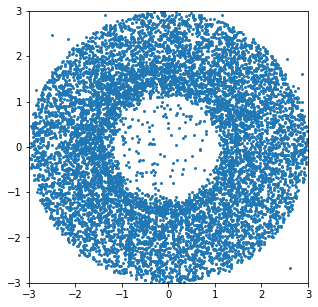

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
plt.scatter(xy[:,:,0],xy[:,:,1],marker=".",linewidth=0)

One can see that some particles changed their orbits quite significantly, while others seem to stay roughly on circular orbits. To investigate this a bit further, we now calculate and plot the relative change of the test particles' semi-major axis over the duration of the simulation. We'll plot it as a function of the initial period ratio $r=P_{\rm test particle}/P_{\rm planet}$ for which we make use of Kepler's law, $P = 2\pi\sqrt{a^3/GM}$.

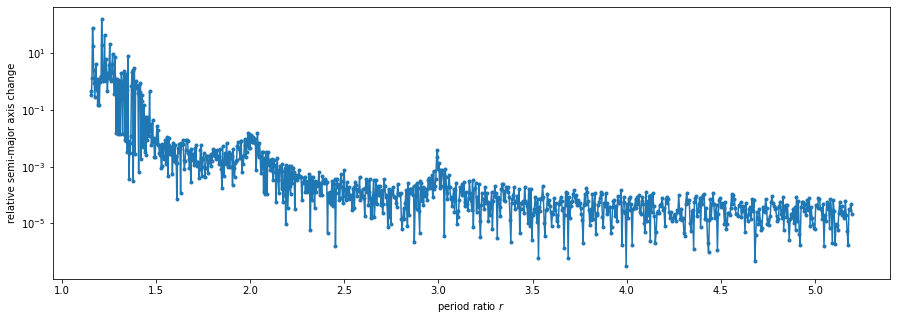

In [7]:
orbits = sim.orbits()[1:]
a_final = [o.a for o in orbits]
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_yscale('log')
ax.set_xlabel(r"period ratio $r$")
ax.set_ylabel("relative semi-major axis change")
plt.plot(np.power(a_initial,1.5),(np.fabs(a_final-a_initial)+1.0e-16)/a_initial,marker=".");

Very close to the planet test particles change their semi-major axis by order unity. These particles have a close encounter with the planet and get scattered.

We also see two peaks at $r=2$ and $r=3$. These correspond to mean motion resonances. We can also see the mean motion resonances by plotting the eccentricities of the particles. 

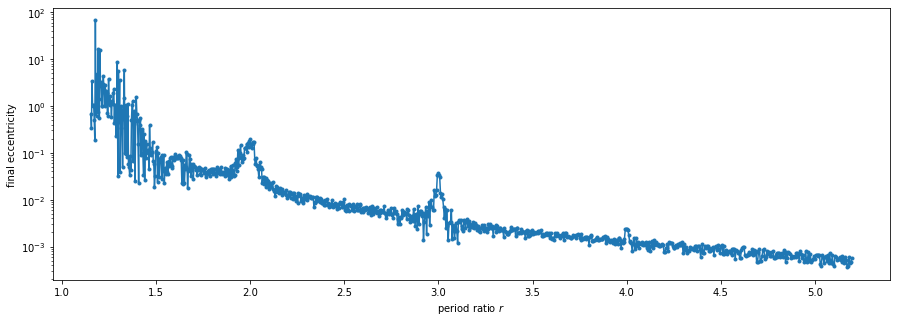

In [8]:
e_final = np.array([o.e for o in orbits])
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
#ax.set_ylim([0,1])
ax.set_yscale('log')
ax.set_xlabel(r"period ratio $r$")

ax.set_ylabel("final eccentricity")
plt.plot(np.power(a_initial,1.5),e_final+1.0e-16,marker=".");

Once again, we see peaks at $r=2$ and $r=3$, corresponding to the 2:1 and 3:1 mean motion resonance. You can even see a hint of an effect at $r=4$, the 4:1 mean motion resonance.

In the above example, the planet did not change its semi-major axis as the test particles have zero mass and do not affect any other particles. 

In [9]:
print(sim.orbits()[0].a)

1.0000000000000027


Let us change this assumption by allow the test particles to have a small mass and influence the planet. Test particles do still not influence other test particles. This setup is referred to as type 1 in REBOUND.

In [10]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1e-3, a=1, e=0.05)
sim.move_to_com()
sim.integrator = "whfast"
sim.dt = 0.05
N_testparticle = 1000
a_initial = np.linspace(1.1, 3, N_testparticle)
for a in a_initial:
    sim.add(a=a,f=np.random.rand()*2.*np.pi, m=1e-7)

As above, we set `N_active` to the number of massive bodies. We also set the `testparticle_type` to 1, which allows interactions between test particles and massive particles, but not between test particles themselves. This is similar to what MERCURY calls small bodies.

In [11]:
sim.N_active = 2
sim.testparticle_type = 1

If we integrate this simulation forwards in time and output the semi-major axis of the planet, we can see that it changed slightly from the initial $a=1$ due to interactions with the test particles. 

In [12]:
sim.integrate(t_max)
print(sim.orbits()[0].a)

0.9977589957255236
